# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

**ПРИВЕТСТВИЕ РЕВЬЮЕРУ**. Очень много времени у меня ушло на этот проект, очень много ядер полегло локально и на платформе Практикума, и на каггле, где в итоге и выполнял проект, хотя даже их 30 Гб RAM не хватало иногда в процессе подбора параметров лемматизатора, логистической регрессии и TfidfVectorizer'а. Оставляю закомментированные ячейки с частями кода, которые использовал по пути к побитию бейзлайна, чтобы были видны этапы работы. Понимаю, что проект может выглядеть сыровато, но после длительных мучений над метрикой хочется понять, в ту ли сторону я вообще шёл. 

Загрузим все необходимые модули и библиотеки.

In [1]:
import pandas as pd

from tqdm import tqdm, tqdm_notebook
import os
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

import spacy
import en_core_web_sm
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [3]:
df = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [5]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
df.duplicated().sum()

0

Данные загружены. Пропусков и дубликатов нет. Наблюдаются лишние символы, позже обработаем их с помощью регулярных выражений.

Выделим столбец с текстом комментария (по сути, features) и целевой столбец с указанием, токсичен ли комментарий.

In [7]:
X = df['text']
y = df['toxic']

Напишем функцию с регулярными выражениями для очистки текста.

In [8]:
def clear_text(text):
    text = text.lower()
    text = text.replace("' ", "'")
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"(\w)(\1{2,})","\\1",text,flags=re.MULTILINE) #Удаление из комментария повторяющихся символов
    text = re.sub(r"[\n\t\\\/]"," ",text, flags=re.MULTILINE) #комментарии типа «\ n», «\ t», «/» и «\».
    text = re.sub(r'\d'," ",text, flags=re.MULTILINE) #удаление цифр из комментария
    text = re.sub(r"<.*>"," ",text, flags=re.MULTILINE) # удаление HTML-тегов из комментария
    text = re.sub(r"[^A-Za-z' ]", ' ', text)
    return ' '.join(text.split())

In [9]:
tqdm_notebook().pandas()
X = df['text'].progress_apply(lambda x: clear_text(x))  

/tmp/ipykernel_117/569912314.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


0it [00:00, ?it/s]

  0%|          | 0/159292 [00:00<?, ?it/s]

In [10]:
disabled_pipes = ["parser",  "ner"]
nlp = spacy.load("en_core_web_sm", disable=disabled_pipes)

In [11]:
lemm_texts = []

for doc in tqdm(nlp.pipe(X.values, disable = ['ner', 'parser']), total=X.shape[0]):
    lemm_text = " ".join([i.lemma_ for i in doc])    
    lemm_texts.append(lemm_text) 


100%|██████████| 159292/159292 [08:24<00:00, 315.92it/s]


In [13]:
lemm_texts

['explanation why the edit make under my username hardcore metallica fan be revert they be not vandalism just closure on some gas after I vote at new york doll fac and please do not remove the template from the talk page since I be retire now',
 "d'aww he match this background colour I be seemingly stuck with thank talk january utc",
 'hey man I be really not try to edit war it just that this guy be constantly remove relevant information and talk to I through edit instead of my talk page he seem to care more about the formatting than the actual info',
 'more I can not make any real suggestion on improvement I wonder if the section statistic should be later on or a subsection of type of accident I think the reference may need tidy so that they be all in the exact same format ie date format etc I can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let I know there appear to be a backlog on article for revi

In [14]:
stop_words = set(stopwords.words('english')) 

In [15]:
X.head()

0    explanation why the edits made under my userna...
1    d'aww he matches this background colour i am s...
2    hey man i am really not trying to edit war it ...
3    more i cannot make any real suggestions on imp...
4    you sir are my hero any chance you remember wh...
Name: text, dtype: object

In [16]:
'''
def lemmatize_spacy(text):
    lemm_list = nlp(text)
    lemm_text = str(lemm_list)
        
    return lemm_text
'''

'\ndef lemmatize_spacy(text):\n    lemm_list = nlp(text)\n    lemm_text = str(lemm_list)\n        \n    return lemm_text\n'

In [17]:
#X = X.progress_apply(lambda x: lemmatize_spacy(x))

Разделим на выборки, используя параметр stratify, чтобы сохранить пропорции распределения целевого признака, ведь наш датафрейм очень несбалансированный: соотношение нетоксичных и токсичных комментариев составляет 1:8,84

In [18]:
X_train, X_test, y_train, y_test = train_test_split(lemm_texts, y, test_size = 0.1, random_state = 6767, stratify=df.toxic)

In [19]:
len(X_train)

143362

In [20]:
len(X_test)

15930

In [21]:
class_0_w = 1
class_1_w = len(y_train[y_train==0]) / len(y_train[y_train==1])
print(class_1_w)

8.841559689709618


На графиках ниже увидим, что распределение целевого признака в тренировочной и тестовой выборках примерно одинаковое, stratify выполнил свою роль.

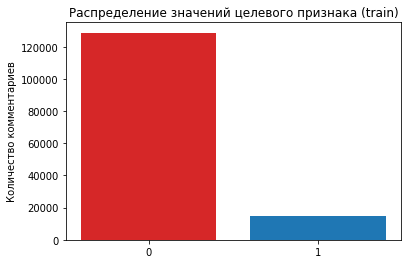

In [22]:
fig, ax = plt.subplots()

toxic = ['0', '1']
counts = [y_train.value_counts()[0], y_train.value_counts()[1]]
bar_colors = ['tab:red', 'tab:blue']

ax.bar(toxic, counts, color=bar_colors)

ax.set_ylabel('Количество комментариев')
ax.set_title('Распределение значений целевого признака (train)')

plt.show()

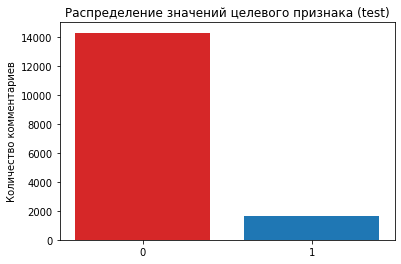

In [23]:
fig, ax = plt.subplots()

toxic = ['0', '1']
counts = [y_test.value_counts()[0], y_test.value_counts()[1]]
bar_colors = ['tab:red', 'tab:blue']

ax.bar(toxic, counts, color=bar_colors)

ax.set_ylabel('Количество комментариев')
ax.set_title('Распределение значений целевого признака (test)')

plt.show()

Теперь применим TfidfVectorizer для перевода текстовых значений в векторные.

In [24]:
%%time
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)
#vectorizer = TfidfVectorizer(ngram_range = (1,1), stop_words=stopwords.words('english'), min_df = 0.0005, norm='l2', use_idf=False)

CPU times: user 5.75 s, sys: 75.9 ms, total: 5.82 s
Wall time: 5.84 s


In [25]:
X_train_vect.shape

(143362, 142707)

## Обучение

Обучение моделей с таким объёмным датафреймом требует больших ресурсов и времени, поэтому перебирать в GridSearch будем небольшое количество гиперпараметров. Главное - сохранить баланс весов классов (class_weight = 'balanced').

In [26]:
%%time
lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords.words('english'))),
    ('clf', LogisticRegression(random_state=123456, class_weight='balanced'))])

lr_params = {'clf__C': [0.3, 1, 10],
             'clf__warm_start': [True, False]}

lr_grid = GridSearchCV(estimator=lr_pipe, 
                       param_grid=lr_params, 
                       cv=3, 
                       scoring='f1',
                       refit='f1')
lr_grid.fit(X_train, y_train)
lr_best_parameters = lr_grid.best_params_
lr_grid_best_score = lr_grid.best_score_

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

CPU times: user 6min 21s, sys: 5min 47s, total: 12min 9s
Wall time: 12min 10s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
print(lr_best_parameters)
print(lr_grid_best_score)

{'clf__C': 10, 'clf__warm_start': True}
0.766063752352277


DecisionTree

In [31]:
%%time
dtc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords.words('english'))),
    ('clf', DecisionTreeClassifier(random_state=12345, class_weight = 'balanced'))])
     
dtc_params = {'clf__max_depth': [2, 5, 10],
            'clf__splitter': ['best', 'random']}

dtc_grid = GridSearchCV(estimator=dtc_pipe, 
                       param_grid=dtc_params, 
                       cv=3, 
                       scoring='f1',)
dtc_grid.fit(X_train, y_train)
dtc_best_parameters = dtc_grid.best_params_
dtc_grid_best_score = dtc_grid.best_score_

print(dtc_best_parameters)
print(dtc_grid_best_score)

{'clf__max_depth': 10, 'clf__splitter': 'best'}
0.5641930647842149
CPU times: user 2min 18s, sys: 1.26 s, total: 2min 19s
Wall time: 2min 19s


Модель решающего дерева с задачей справляется существенно хуже логистической регрессии (F1 0,56 против 0,77 на трейне). Поэтому на тестовой выборке применим регрессию.

In [29]:
test_pred_logreg = lr_grid.predict(X_test)

In [30]:
test_score_logreg = f1_score(y_test, test_pred_logreg)
test_score_logreg

0.7636159460976979

## Выводы

Модель решающего дерева с задачей справляется существенно хуже логистической регрессии (F1 0,54 против 0,76 на трейне). Поэтому тестировали модель логистической регрессии, которая на тесте тоже превысила метрику в 0,75, т.е. задача решена.

Параметры модели:
{'C': 10, 'warm_start': True}
